In [1]:
import torch
import torch.nn as nn

import os
import random
import librosa
import pickle
import scipy
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False, fscale=2, figsize=(8, 6))

from IPython.display import Audio, display
from tqdm.notebook import tqdm
from pypesq import pesq
from pystoi import stoi
from matplotlib import cm
from scipy.io import wavfile
from argparse import Namespace
from collections import OrderedDict
from sklearn.decomposition import PCA

from const import Const
from preprocess import *
from model import forward_submodule, get_device, AutoEncoder
from main import args

args.device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [2]:
def train(model, dataset, from_epoch, batch_size, valid_loss_threshold, loss_coef, loss_fn, optimizer, save_filename, dataset_path='.'):
    try:
        os.makedirs(os.path.dirname(save_filename))
    except:
        pass
    
    device = get_device(model)
    
    epoch = from_epoch + 1
    saved_epoch = from_epoch
    early_stop = 0
    min_valid_loss = valid_loss_threshold
    loss_hist = { 'train loss': [], 'valid loss': [] }
    
    with tqdm(total=len(dataset['Train'])) as pbar1, \
         tqdm(total=len(dataset['Valid'])) as pbar2:
        
        while True:
            # ===== Training =====
            bs = 0
            loss = 0

            pbar1.reset()
            pbar1.set_description_str(f'(Epoch {epoch})')
            random.shuffle(dataset['Train'])
            for sample_id, elec, clean_spec in dataset['Train']:
                pred = model(elec)
                loss += loss_fn(pred, clean_spec)
                bs += 1
                if bs >= batch_size:
                    loss /= bs
                    train_loss = loss.item()

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    loss_hist['train loss'].append(train_loss)
                    loss = 0
                    bs = 0

                pbar1.update()

            if bs != 0:
                loss /= bs
                train_loss = loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                loss_hist['train loss'].append(train_loss)
                loss = 0
                bs = 0

            pbar1.set_postfix(loss=train_loss)

            # ===== Validation =====
            valid_loss = 0
            valid_sample = 0
            pbar2.reset()
            pbar2.set_description_str(f'(Saved Epoch {saved_epoch}), min valid loss: {min_valid_loss:.3f}')
            for sample_id, elec, clean_spec in dataset['Valid']:
                with torch.no_grad():
                    pred = model(elec)
                    valid_loss += loss_fn(pred, clean_spec).item()
                valid_sample += 1

                pbar2.set_postfix(valid_loss=valid_loss/valid_sample)
                pbar2.update()
            
            valid_loss /= valid_sample
            loss_hist['valid loss'].append(valid_loss)

            if valid_loss < min_valid_loss:
                min_valid_loss = valid_loss
                saved_epoch = epoch
                model.save_model(f'{save_filename}.pt', saved_epoch, valid_loss)
                early_stop = 0
            else:
                early_stop += 1

            pbar2.set_description_str(f'(Saved Epoch {saved_epoch}), min valid loss: {min_valid_loss:.3f}')
            epoch += 1

            plt.plot(loss_hist['train loss'])
            plt.plot(np.linspace(0, len(loss_hist['train loss']), len(loss_hist['valid loss'])), loss_hist['valid loss'])
            plt.legend(['Train', 'Valid'])
            plt.tight_layout(pad=0.2)
            plt.show()
            
            if early_stop >= 5:
                pbar1.close()
                pbar2.close()
                break

Model './checkpoint/AutoEncoder/PCA_AE16_BiLSTM32_L12NR S.pt' loaded.
Caching data ...
Training set size: 222, Validation set size: 27


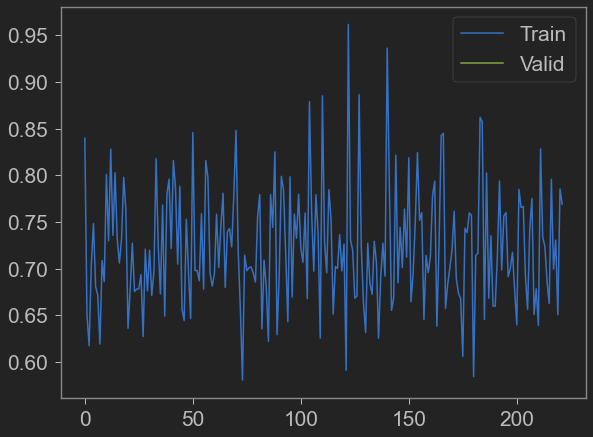

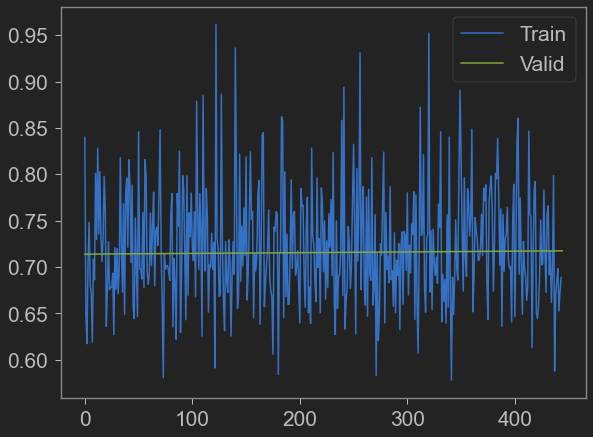

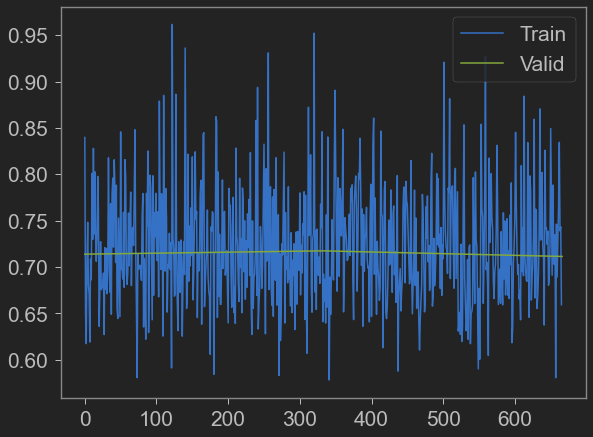

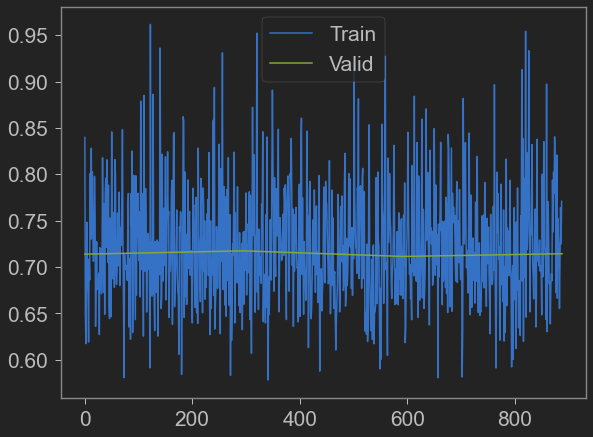

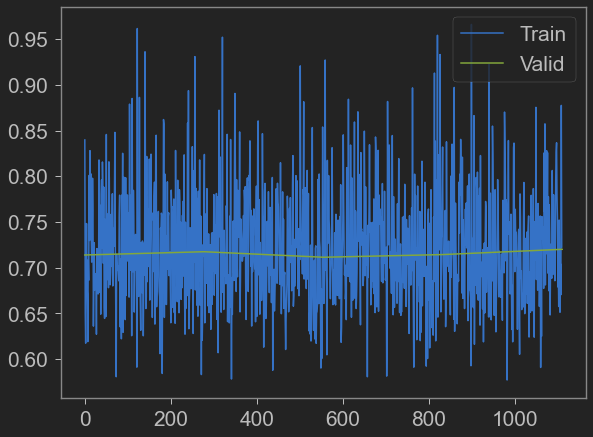

In [8]:
if __name__ == '__main__':
    model_name = 'PCA_AE16_BiLSTM32_L12NR S'
    model, from_epoch, valid_loss_threshold = AutoEncoder(
        Encoder=nn.Sequential(OrderedDict([
            ('lstm_0', nn.LSTM(16, 16, batch_first=True, bidirectional=True)),
            ('L_0', nn.Linear(32, 12)),
            ('norm_0', nn.LayerNorm(12, elementwise_affine=True)),
            ('relu_0', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
        ])),
        
        Decoder=nn.Sequential(OrderedDict([
            ('L_0', nn.Linear(12, 257)),
            ('relu_0', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
        ])),
    ).load_model(os.path.join(args.AE_checkpoint_path, f'{model_name}.pt'), device=args.device)
    
    print('Caching data ...')
    pca = pickle.load(open(os.path.join(args.AE_checkpoint_path, 'PCA16.pkl'), 'rb'))
    dataset = cache_clean_data(elec_preprocessors=[pca], force_update=False, split_ratio=args.split_ratio, dataset_path=args.dataset_path, device=args.device)
    print(f"Training set size: {len(dataset['Train'])}, Validation set size: {len(dataset['Valid'])}")
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    train(model, dataset,
          from_epoch, args.batch_size,
          valid_loss_threshold, args.loss_coef,
          loss_fn, optimizer,
          save_filename=os.path.join(args.AE_checkpoint_path, model_name),
          dataset_path=args.dataset_path,
    )

model_name: PCA_AE16_BiLSTM32_L12NR S
Model './checkpoint/AutoEncoder/PCA_AE16_BiLSTM32_L12NR S.pt' loaded.
PESQ:  1.9117071628570557
STOI:  0.6083696800522419
ESTOI: 0.512781733241916


<Figure size 1440x360 with 0 Axes>

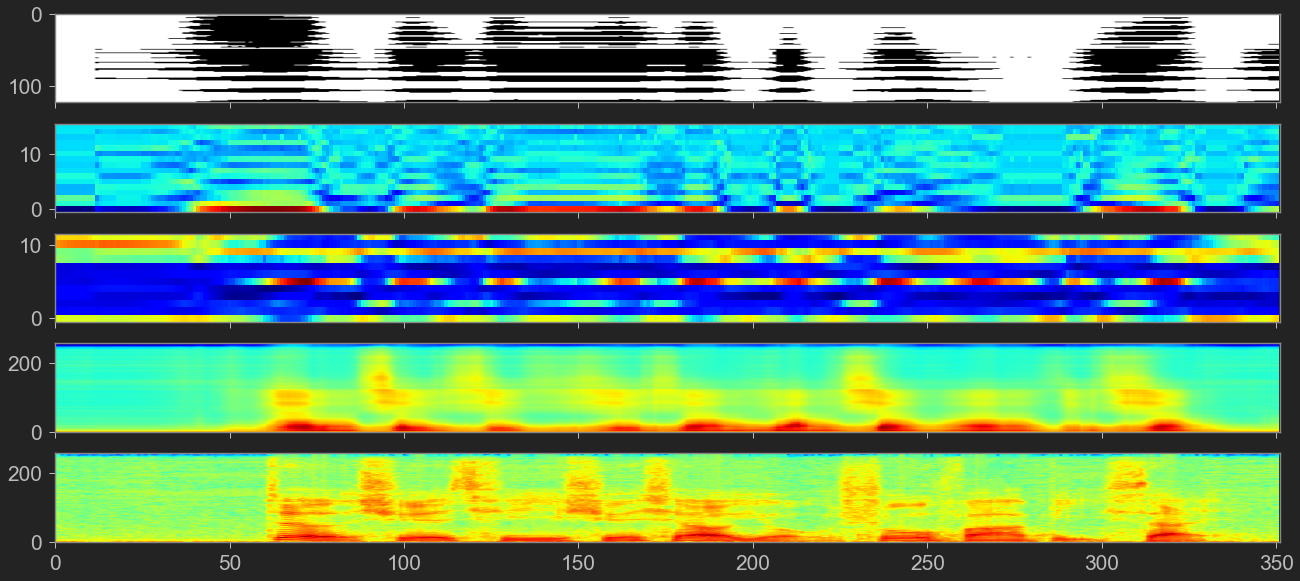

In [7]:
import re

def test(model, test_sample, pca=None):
    wave_data = read_wave(f'../../Dataset/Testing/Clean/a1/{to_TMHINT_name(test_sample)}.wav')
    Sy, phasey, _, _ = wave2spec(wave_data)

    elec_data = np.genfromtxt(f'../../raw data/split electro/E{test_sample:03d}.csv', delimiter=',', dtype=np.float32)
    elec_data = elec_data[:Sy.shape[1]-Const.SHIFT, 1:]
    elec_data = np.vstack([np.zeros((Const.SHIFT, elec_data.shape[1])), elec_data])
    elec = torch.Tensor([elec_data]).to(args.device)
    
    if pca is not None:
        elec = torch.Tensor([pca.transform(elec[0].cpu().numpy())]).to(args.device)
    
    with torch.no_grad():
        hidden = forward_submodule(model.Encoder, elec)
        Sy_ = forward_submodule(model.Decoder, hidden)
    elec = elec[0].cpu().detach().numpy().T
    hidden = hidden[0].cpu().detach().numpy().T
    Sy_ = Sy_[0].cpu().detach().numpy().T
    
    pred = spec2wave(Sy_, phasey)
    clean = spec2wave(Sy, phasey)
    
    sr = 16000
    print('PESQ: ', pesq(clean, pred, sr))
    print('STOI: ', stoi(clean, pred, sr, False))
    print('ESTOI:', stoi(clean, pred, sr, True))
    
    display(Audio(clean, rate=sr, autoplay=False))
    display(Audio(pred, rate=sr, autoplay=False))
    
    plt.figure(figsize=(20, 5))
#     plt.imshow(Sy, origin='lower', aspect='auto', cmap='jet')
    f, axes = plt.subplots(5, 1, sharex=True, figsize=(18, 8))
    axes[0].set_xlim(0, Sy.shape[1])
    axes[0].imshow(elec_data.T, aspect='auto', cmap='binary')
    axes[1].imshow(elec, origin='lower', aspect='auto', cmap='jet')
    axes[2].imshow(hidden, origin='lower', aspect='auto', cmap='jet')
    axes[3].imshow(Sy_, origin='lower', aspect='auto', cmap='jet')
    axes[4].imshow(Sy, origin='lower', aspect='auto', cmap='jet')

    plt.tight_layout(pad=0.2)
#     plt.savefig(os.path.join(args.AE_checkpoint_path, f'S39.png'))
    plt.show()

if __name__ == '__main__':
    sample = 1

    model_names = [
#         'AE124_BiLSTM12NR S',
#         'AE_124_LSTM_12_LeakyReLU S',
#         'AE_124_LSTM_12_LeakyReLU S V2',
#         'AE124_LSTM64_L12NR S',
#         'AE124_CNN_LSTM64_L32NR_L8NR S',
#         'AE124_CNN_LSTM64_L32NR_L12NR S',
        
#         'PCA_AE16_BiLSTM32_L6NR S',
        'PCA_AE16_BiLSTM32_L12NR S',
#         'PCA_AE12_BiLSTM24_L12NR S',
    ]
    
    for model_name in model_names:
        print(f'model_name: {model_name}')
        model, _, _ = AutoEncoder().load_model(os.path.join(args.AE_checkpoint_path, f'{model_name}.pt'), args.device)
#         print(model)
        
        if 'pca' in model_name.lower():
            components = int(re.findall(r'\d+', model_name)[0])
            pca = pickle.load(open(os.path.join(args.AE_checkpoint_path, f'PCA{components}.pkl'), 'rb'))
        else:
            pca = None
        test(model, sample, pca)

In [9]:
def mean(lst):
    return sum(lst) / len(lst)

import re
def analyze(model, model_name):
    pca = None
    if 'pca' in model_name.lower():
        components = int(re.findall(r'\d+', model_name)[0])
        pca = pickle.load(open(os.path.join(args.AE_checkpoint_path, f'PCA{components}.pkl'), 'rb'))
    
    dataset = cache_clean_data(elec_preprocessors=[pca], is_training=False, dataset_path=args.dataset_path, force_update=False, device=args.device)
    
    performance = { 'pesq': [], 'stoi': [], 'estoi': [] }
    sr = 16000
    
    loss = []
    for sample, elec, clean in dataset['Test']:
        spec, phase, _, _ = wave2spec(clean)
        spec = torch.Tensor([spec.T]).to(args.device)
        with torch.no_grad():
            pred = model(elec)
            loss.append(loss_fn(pred, spec).item())

        pred = pred[0].cpu().detach().numpy().T
        pred = spec2wave(pred, phase)

        performance['pesq'].append(pesq(clean, pred, sr))
        performance['stoi'].append(stoi(clean, pred, sr, False))
        performance['estoi'].append(stoi(clean, pred, sr, True))

    print('mean loss:', mean(loss))
    print('PESQ: ', mean(performance['pesq']))
    print('STOI: ', mean(performance['stoi']))
    print('ESTOI:', mean(performance['estoi']))
    print()

if __name__ == '__main__':
    model_names = [
#         'AE124_BiLSTM12NR S',
#         'AE_124_LSTM_12_LeakyReLU S',
#         'AE_124_LSTM_12_LeakyReLU S V2',
#         'AE124_LSTM64_L12NR S',
#         'AE124_CNN_LSTM64_L32NR_L8NR S',
#         'AE124_CNN_LSTM64_L32NR_L12NR S',
        
#         'PCA_AE16_BiLSTM32_L6NR S',
        'PCA_AE16_BiLSTM32_L12NR S',
#         'PCA_AE12_BiLSTM24_L12NR S',
#         'PCA_AE12_BiLSTM32_L12NR S',
#         'PCA_AE21_BiLSTM32_L32NR S',
    ]
    
    loss_fn = nn.MSELoss()
    for model_name in model_names:
        print(f'model_name: {model_name}')
        model, _, _ = AutoEncoder().load_model(os.path.join(args.AE_checkpoint_path, f'{model_name}.pt'), args.device)
#         print(model)
        analyze(model, model_name)

model_name: PCA_AE16_BiLSTM32_L12NR S
Model './checkpoint/AutoEncoder/PCA_AE16_BiLSTM32_L12NR S.pt' loaded.
mean loss: 0.7556318257536206
PESQ:  2.032068989958082
STOI:  0.5914411571670037
ESTOI: 0.3965800950794452



<table style='font-size:150%; padding:10px; border:3px #cccccc solid'>
  <tr align="center" valign="center" style='color:#e6610a; font-weight:bold; font-size:120%'>
    <td style='color:#60a20a'>model name</td>
    <td style='color:#e6a20a'>mean loss</td>
    <td>PESQ</td>
    <td>STOI</td>
    <td>ESTOI</td>
　</tr>
　<tr align="left" valign="top">
    <td style='color:#20a0fa; font-weight:bold'>AE124_BiLSTM12NR S</td>
    <td>0.8933024900300163</td>
    <td>1.9006785801478794</td>
    <td>0.5419787206133356</td>
    <td>0.3567816978445381</td>
　</tr>
  <tr align="left" valign="top">
    <td style='color:#20a0fa; font-weight:bold'>PCA_AE16_BiLSTM32_L6NR S</td>
    <td>0.7561260265963418</td>
    <td>2.030931559630803</td>
    <td style='color:#008800; font-weight:bold'>0.6005091660924574</td>
    <td>0.38060393429501344</td>
　</tr>
  <tr align="left" valign="top">
    <td style='color:#20a0fa; font-weight:bold'>PCA_AE16_BiLSTM32_L12NR S</td>
    <td style='color:#008800; font-weight:bold'>0.7556318257536206</td>
    <td>2.032068989958082</td>
    <td>0.5914411571670037</td>
    <td>0.3965800950794452</td>
　</tr>
  <tr align="left" valign="top">
    <td style='color:#20a0fa; font-weight:bold'>PCA_AE12_BiLSTM24_L12NR S</td>
    <td>0.7775026542799813</td>
    <td>2.0924623591559275</td>
    <td>0.5908420696988249</td>
    <td style='color:#008800; font-weight:bold'>0.4098353818142674</td>
　</tr>
  <tr align="left" valign="top">
    <td style='color:#20a0fa; font-weight:bold'>PCA_AE12_BiLSTM32_L12NR S</td>
    <td>0.7595789849758148</td>
    <td>2.0241294588361467</td>
    <td>0.5880038715999908</td>
    <td>0.39624309467629276</td>
　</tr>
  <tr align="left" valign="top">
    <td style='color:#20a0fa; font-weight:bold'>PCA_AE21_BiLSTM32_L32NR S</td>
    <td>0.7742307909897396</td>
    <td style='color:#008800; font-weight:bold'>2.101714483329228</td>
    <td>0.5978913182237082</td>
    <td>0.40044979104945444</td>
　</tr>
</table>